<a href="https://colab.research.google.com/github/RodrigoAVargasHdz/CohortProject_2021/blob/main/Week1_Trapped_Ions/QCDL_week1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation of Julia in google colab

## Running on Google Colab
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia (the Jupyter kernel for Julia) and other packages. You can update `JULIA_VERSION` and the other parameters, if you know what you're doing. Installation takes 2-3 minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the _Checking the Installation_ section.

* _Note_: If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools PyCall PyPlot PastaQ ITensors"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system (if you ever ask for help or file an issue about Julia, you should always provide this information).

In [2]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake-avx512)
Environment:
  JULIA_NUM_THREADS = 4


# Utils


In [3]:
using PastaQ
using ITensors
using PyPlot
using Statistics

## 1-qbit gate

In [4]:
function PastaQ.gate(::GateName"R"; theta::Real, phi::Real)
    [
        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
    ]
end

## 2-qbit gate

In [5]:
function PastaQ.gate(::GateName"M"; Theta::Real)
    [
        cos(Theta)    0    0    (-im * sin(Theta))
        0    cos(Theta)    (-im * sin(Theta))    0
        0    (-im * sin(Theta))    cos(Theta)    0
        (-im * sin(Theta))    0    0    cos(Theta)
    ]
end

## 1-qbit flip-gate 
(for task 2)

In [6]:
function PastaQ.gate(::GateName"SigmaX"; theta::Real, phi::Real)
    [
        0    1
        1     0
    ]
end

## `# get_gates` creates the sequence of gates (gates) and the MPS that simulates the quantum computation (psi).

In [7]:
function get_gates(N, depth)
    # Random circuit.
    gates = Vector{Tuple}[]

    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end

    psi = runcircuit(N, gates)
    return gates, psi
end

get_gates (generic function with 1 method)

# Task 1

## computing $| <x|\psi> |^2$ with samples

``` # f_counts ``` counts the nubmer of samples for all $x$ states. The main function is abased on  ``` # getsamples ``` from PastaQ.


In [8]:
function f_counts_old(psi,N,nshots)
  data = getsamples(psi,nshots)
  
  qi_temp = reverse.(Iterators.product(fill(0:1,N)...))[:] #tuples
  # convert from tuples to array
  qi = zeros(Int8,(1,N)) 
  for q in qi_temp
    x = [i for i in q] 
    qi = vcat(qi, transpose(x))
  end
  qi = qi[2:end,:]

  q_counts = zeros(Int8,size(qi)[1])
  j = 1 # index for the quantum state
  for x in eachrow(qi)
    for d in eachrow(data)
      if x == d
        @inbounds q_counts[j] += 1
      end
    end
    j = j + 1
  end 
  return q_counts
end 

f_counts_old (generic function with 1 method)

In [9]:
function f_counts(psi,N,nshots)
  data = getsamples(psi,nshots)
  qi = zeros(Int,(1,N))
  for x in 0:2^N-1
    y = digits(x, base=2, pad=N)
    qi = vcat(qi,transpose(y))
  end
  qi = qi[2:end,:]

  q_counts = zeros(Int8,size(qi)[1])
  j = 1 # index for the quantum state
  for x in eachrow(qi)
    for d in eachrow(data)
      if x == d
        @inbounds q_counts[j] += 1
      end
    end
    j = j + 1
  end 
  return q_counts
end 


f_counts (generic function with 1 method)

``` # f_q_prob ``` computes the probability from the samples generated.

In [10]:
function f_q_prob(N,psi,nshots_total)
  n0 = nshots_total/100
  q_counts_total = f_counts(psi,N,100)

  for i in 2:n0
    q_counts = f_counts(psi,N,100)
    q_counts_total = hcat(q_counts_total, q_counts)
  end
  q_counts = sum(q_counts_total,dims=2)
  # println("counts => ", q_counts)
  prob_q = q_counts/nshots_total
  # println("prob => ", prob_q)
  return prob_q
end

f_q_prob (generic function with 1 method)

## computing $| <x|\psi> |^2$ with tensors



``` # f_psi_sqr ``` computes the square $c_i$ for each $x$ for the probability of each $x$. 



In [11]:
function f_psi_sqr(N,psi)
  sites = siteinds("S=1/2",N)
  states = [isodd(n) ? "Up" : "Dn" for n=1:N]
  A = zeros(2^N,1)
  i = 1
  for x in 0:2^N-1
    y = digits(x, base=2, pad=N)
    sites = siteinds("S=1/2",N)
    for n in 1:N
      if y[n] == 0
        states[n] = "Dn"
      else
        states[n] = "Up"
      end
    end
      xpsi = productMPS(sites,states)
      a = inner(xpsi, psi)
      b = a * a'
      A[i,1] = b
      i = i + 1
  end
  psi_sqr = A[Iterators.reverse(1:size(A)[1]),:]
  return psi_sqr
end

f_psi_sqr (generic function with 1 method)

## Speckle  pattern plot

The probabilty to get each $x$ from a random circuit using a sampling technique (`# f_q_prob`) and excat simulation through an MPS technique (`# f_psi_sqr`).

We study the change as a function of number of qbits (N) and the depth of the quantum circuit (depth).

```
# GetResults
```
utility function to get the data for a single Q-circuit for N qbits and with given depth. Variable nshots is needed for computing the probability through samples (`# getsamples`).



In [12]:
function GetResults(N,depth,nshots)
  
  gates, psi = get_gates(N,depth)
  prob_q = f_q_prob(N,psi,nshots)
  psi_sqr = f_psi_sqr(N,psi)

  return prob_q, psi_sqr
end

GetResults (generic function with 1 method)

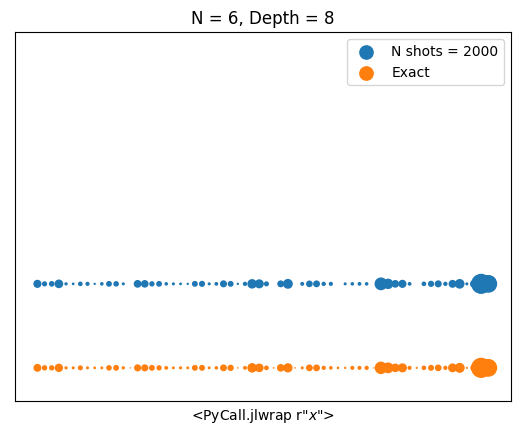

In [13]:
# Illustrate the dataset.
N = 6  #@param {type:"slider", min:2, max:8, step:1}
depth = 8   #@param {type:"slider", min:1, max:30, step:1}
nshots = 2000
prob_q, psi_sqr = GetResults(N, depth,nshots)

n = size(prob_q) # 2^n possible qubits
q_index = 1:1:n[1]#index of QBITS
i_temp = zeros(1, size(q_index)[1])

str_title = "N = $N, Depth = $depth"
plt.title(str_title)
plt.scatter(q_index,0.0025.+i_temp,s=1000*prob_q,label ="N shots = $nshots")
plt.scatter(q_index,i_temp,s=1000*psi_sqr,color="tab:orange",label ="Exact")
plt.xticks([])
plt.yticks([])
plt.xlabel(r"$x$")
plt.ylim(-0.001,0.01)
plt.legend()
plt.show()

# Task2

Study the effect a single random flip has in the final quantum state for a random quantum circuit. 
Here we model a random flip using a 1-qbit gate ($\sigma_{x}$). 

`# get_rnd_gates` generates a single random circuit with a random flip gate. It returns both, the "clean" random circuit (no $\sigma_{x}$), and the random circuit with a random flip ($\sigma_{x}$).

In [14]:
function get_rnd_gates(N, depth)
  gates,psi = get_gates(N, depth)
  gates_clean = copy(gates)

  i = rand(1:N,1)[1]# random qubit
  j = rand(1:depth,1)[1] # random location in the gates
  rand_gate = Tuple[]
  gate = ("SigmaX", i, (theta=2pi*rand(), phi=2pi*rand()))
  push!(rand_gate,gate)
  insert!(gates,j,rand_gate)

  return gates_clean, gates
end

get_rnd_gates (generic function with 1 method)

In [15]:
function GetRndResults(N,depth)
  gates_cln, gates_rnd = get_rnd_gates(N,depth)

  psi_cln = runcircuit(N, gates_cln)
  psi_rnd = runcircuit(N, gates_rnd)

  psi_cln_sqr = f_psi_sqr(N,psi_cln)
  psi_rnd_sqr = f_psi_sqr(N,psi_rnd)

  return psi_cln_sqr, psi_rnd_sqr

end


GetRndResults (generic function with 1 method)

The following figure demonstrate the sum of the abosolute probability difference between the "clean" random circuit with a single random flip. 
\begin{eqnarray}
error = \sum_{i}^{2^{N}} \left | p_{i}(x_i) - \hat{p}_{i}(x_i) \right |
\end{eqnarray}
here, $p_{i}(x_i)$ is the probability of $x_i$ and $\hat{p}_{i}(x_i)$ is the probability of $x_i$ with a random flip. 



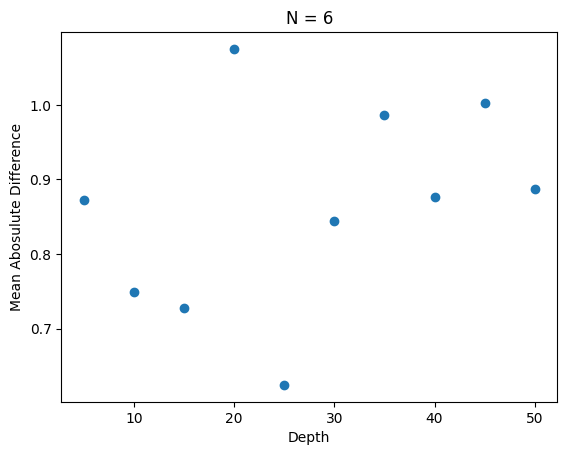

In [16]:
# depth_ = round.(Int,range(1, 100,length = 10))
depth_ = 5 .*(1:1:10)

abs_diff = []

for d in depth_
  psi_cln_sqr, psi_rnd_sqr = GetRndResults(N, d)
  temp = sum(abs.(psi_cln_sqr-psi_rnd_sqr))/size(psi_cln_sqr)[2]
  append!(abs_diff,temp)
end

str_title = "N = $N"
plt.title(str_title)
plt.scatter(depth_,abs_diff)
plt.xlabel("Depth")
plt.ylabel("Mean Abosulute Difference")
#plt.legend()
plt.show()



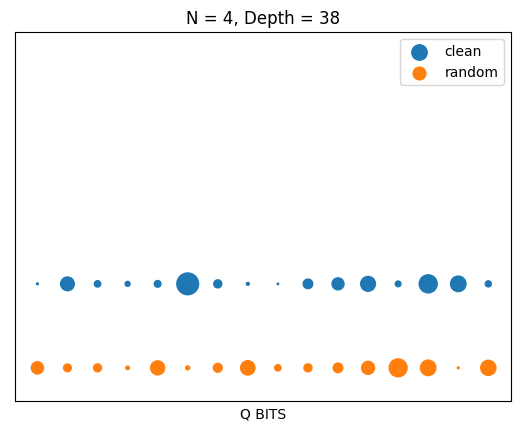

In [17]:
# Illustrate the dataset.
N = 4  #@param {type:"slider", min:1, max:5, step:1}
depth = 38   #@param {type:"slider", min:1, max:50, step:1}
nshots = 10000
psi_cln_sqr, psi_rnd_sqr = GetRndResults(N, depth)

n = size(psi_cln_sqr)[1] # 2^n possible qubits
q_index = 1:1:n[1]#index of QBITS
i_temp = zeros(1, size(q_index)[1])

str_title = "N = $N, Depth = $depth"
plt.title(str_title)
plt.scatter(q_index,0.0025.+i_temp,s=1000*psi_cln_sqr,label ="clean")
plt.scatter(q_index,i_temp,s=1000*psi_rnd_sqr,color="tab:orange",label ="random")
plt.xticks([])
plt.yticks([])
plt.xlabel("Q BITS")
plt.ylim(-0.001,0.01)
plt.legend()
plt.show()

## Additional challenge 1
Combine your speckle patterns from Task 2 into an animation that shows the changes in stateprobabilities as a single bit-flip error is moved around in a deep random circuit.

In [18]:
function get_rnd_gates_ij(N, depth,i,j)
  gates,psi = get_gates(N, depth)
  gates_clean = copy(gates)
 # i = rand(1:N,1)[1]# random qubit
 # j = rand(1:depth,1)[1] # random location in the gates

  j = size(gates_clean)[1]*(j/100)
  print(Int(floor(j)))
  rand_gate = Tuple[]
  gate = ("SigmaX", i, (theta=2pi*rand(), phi=2pi*rand()))
  push!(rand_gate,gate)
  insert!(gates,Int(floor(j)),rand_gate)

  return gates_clean, gates
end

get_rnd_gates_ij (generic function with 1 method)

In [19]:
function GetRndResults_ij(N,depth,i,j)
  gates_cln, gates_rnd = get_rnd_gates_ij(N,depth,i,j)

  psi_cln = runcircuit(N, gates_cln)
  psi_rnd = runcircuit(N, gates_rnd)

  psi_cln_sqr = f_psi_sqr(N,psi_cln)
  psi_rnd_sqr = f_psi_sqr(N,psi_rnd)

  return psi_cln_sqr, psi_rnd_sqr

end

GetRndResults_ij (generic function with 1 method)

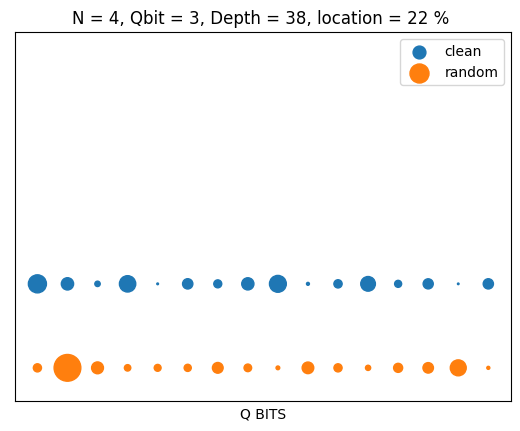

16

In [20]:
# Illustrate the dataset.
N = 4 
depth = 38   #@param {type:"slider", min:1, max:50, step:1}
qbit = 3  #@param {type:"slider", min:1, max:4, step:1}
location = 22   #@param {type:"slider", min:1, max:100, step:1}

nshots = 10000
psi_cln_sqr, psi_rnd_sqr = GetRndResults_ij(N, depth,qbit,location)

n = size(psi_cln_sqr)[1] # 2^n possible qubits
q_index = 1:1:n[1]#index of QBITS
i_temp = zeros(1, size(q_index)[1])

str_title = "N = $N, Qbit = $qbit, Depth = $depth, location = $location % "
plt.title(str_title)
plt.scatter(q_index,0.0025.+i_temp,s=1000*psi_cln_sqr,label ="clean")
plt.scatter(q_index,i_temp,s=1000*psi_rnd_sqr,color="tab:orange",label ="random")
plt.xticks([])
plt.yticks([])
plt.xlabel("Q BITS")
plt.ylim(-0.001,0.01)
plt.legend()
plt.show()

# Task 3 (incomplete)

In [21]:
# loop over different quantum random circuits and collect the probability
function get_probabilites(N,depth,n_circuits,i)
  # N --> number of qbits
  # dpeth --> depth of the circuit
  # n_circuits --> number of random circuits
  # i --> index for the quantum state x

  gates, psi = get_gates(N, depth)
  # psi_sqr_all = f_psi_sqr(N,psi)#
  psi_sqr_all = transpose(f_q_prob(N,psi,1000)) #

  for i in 2:n_circuits
    gates, psi = get_gates(N, depth)
    # psi_sqr = f_psi_sqr(N,psi)
    psi_sqr = transpose(f_q_prob(N,psi,1000))

    psi_sqr_all = vcat(psi_sqr_all, psi_sqr)
  end
  psi_sqr_all = transpose(psi_sqr_all) # (2^N, #circuits)
  q_i_prob = psi_sqr_all[i,:]

  return sort(q_i_prob)
end

get_probabilites (generic function with 1 method)

# cumulative distribution: 
\begin{eqnarray}
1 - e^{-2^{N}p}
\end{eqnarray}


In [22]:
function f_cdf(N,probs)
  return 1. .- exp.((-(2^N)).*probs)
end 

f_cdf (generic function with 1 method)

The change of the cumulative distribution for N qbits as a funciton of the depth of the random circuits.

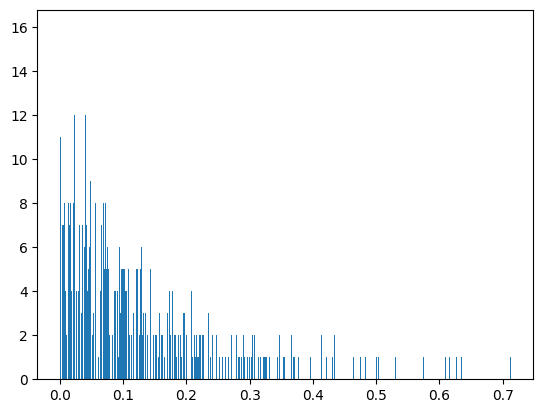

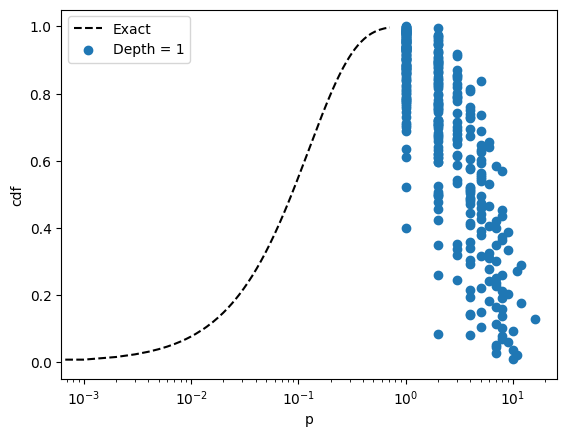

In [23]:
N = 3
n_circuits = 1000

q_i_prob_1 = get_probabilites(N,10,n_circuits,2)

calc_cdf_1 = f_cdf(N,q_i_prob_1)

# cdf_1 = cumsum(q_i_prob_1)#/sum(q_i_prob_1)
count, bins_count = plt.hist(q_i_prob_1, bins=1000)
pdf = count / sum(count)
cdf = cumsum(pdf)

#n, bins, patches = plt.hist(q_i_prob, 50)
#plt.show()

fig, ax = plt.subplots(1, 1)
ax.plot(q_i_prob_1,calc_cdf_1,ls="--",color="k",label = "Exact")
ax.scatter(count,cdf,label = "Depth = 1")

ax.set_xlabel("p")
ax.set_ylabel("cdf")
ax.set_xscale("log")
plt.legend()
plt.show()

In [24]:
p = range(0.001,1.,length=100)

cdf = f_cdf(8,p)

plt.plot(p,cdf)
plt.xcale("log")
plt.show()

LoadError: ignored

# Task 4

`get_gates_dtheta` is a modified version of the original `get_gates` that accounts for the $\Delta \theta$.


In [25]:
function get_gates_dtheta(N, depth, d_theta)
    # Random circuit.
    gates = Vector{Tuple}[]
    gates_dtheta = Vector{Tuple}[]

    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]
        two_qubit_layer_d_theta = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)

            gate_dtheta = ("M", (j, j+1), (Theta=2pi*rand()+ d_theta,))
            push!(two_qubit_layer_d_theta, gate_dtheta)

        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)

        push!(gates_dtheta, one_qubit_layer)
        push!(gates_dtheta, two_qubit_layer_d_theta)
    end

    psi = runcircuit(N, gates)
    psi_dtheta = runcircuit(N, gates_dtheta)

    return gates, psi, gates_dtheta, psi_dtheta
end

get_gates_dtheta (generic function with 1 method)

# Cross-entropy benchmarking (XEB) fidelity

\begin{eqnarray}
{\cal F}_{XEB} = 2^{N} \langle P \rangle - 1 = \frac{2^{N}}{S} \sum_i^{S}P(x_{i}) - 1,
\end{eqnarray}
where $S$ is the total number of samples $x_i$ from the circtuit with the perturbation $\Delta\theta$, $N$ is the number of qbits, and $P(x_{i})$ is the probability of the sample $x_i$ on the unperturbed circuit.

In [29]:
function f_f_xeb(N,depth,d_theta,nsamples)
  gates, psi, gates_dtheta, psi_dtheta = get_gates_dtheta(N,depth,d_theta)
  
  data = getsamples(psi_dtheta,nsamples) #samples from the circuit with \Dela\theta
  psi_sqr = f_psi_sqr(N,psi)  # probabilities from the "clean" circuit

# list of all possible quantum states
  qi = zeros(Int,(1,N))
  for x in 0:2^N-1
    y = digits(x, base=2, pad=N)
    qi = vcat(qi,transpose(y))
  end
  qi = qi[2:end,:]

  f_xeb = 0.
  for d in eachrow(data)
    i = 1
    for q in eachrow(qi)
      if q == d
        f_xeb = f_xeb + (psi_sqr[i])
      end
      i  = i + 1
    end
  end
  f_xeb = (2^N/nsamples)*f_xeb - 1.
  return f_xeb
end

f_f_xeb (generic function with 1 method)

In [32]:
N = 3   #@param {type:"slider", min:2, max:8, step:1}
depth = 350   #@param {type:"slider", min:50, max:500, step:25}
d_theta = 0.1   #@param {type:"slider", min:0.0, max:1.0, step:0.05}
nsamples = 300   #@param {type:"slider", min:100, max:1000, step:100}


f_xeb = f_f_xeb(N,depth,d_theta,nsamples)
println("For a circuit with:")
println("N = $N, depth = $depth, Delta Theta = $d_theta, and Num. Samples = $nsamples")
println("Cross-entropy benchmarking (XEB) fidelity = $f_xeb")


For a circuit with:
N = 3, depth = 350, Delta Theta = 0.1, and Num. Samples = 300
Cross-entropy benchmarking (XEB) fidelity = 0.050533329501441626
